## Imports

In [55]:
# generic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")

# text-preprocessing imports
import re
import nltk
import contractions # for expanding short-form texts
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# text-visualizing
from sklearn.manifold import TSNE

from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [10]:
# LSA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# LDA 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# NMF
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf

# gensim
import gensim
from gensim import models
from gensim.models import LsiModel, LdaModel
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from operator import itemgetter

# pyLDAvis for visualization
import pyLDAvis
import pyLDAvis.lda_model # import pyLDAvis.sklearn -> this doesn't work
pyLDAvis.enable_notebook()

## Problem Statement

* We have a lot of documents and those are from multi-domain and the documents nature are also different. Some might be showing comversation between 2 or more people, some might be giving factual information some might be abstrative in nature.

* The length of the documents are also varying in nature. Some might have 100 words while rest might have around 1000 words so one, document can be 10 times larger then the another document.

* ***To get an idea behind what in general a document is about, we will extract topics out of them. Each document can be respresented in n number of topics but will be only going with the top 3 topics or the top most topic a document might contain to get a gist of the document.***

## 1. Get the Data & Process it in desired format

The `article` field in each `txt` document in the RACE dataset is consolidated into a single `../input/documnets.csv` file for the topic modelling purpose.

In [11]:
%%time 

import os
import tarfile

if not os.path.isdir("../input/raw_data/RACE"):
    tar =  tarfile.open("../input/RACE.tar.gz") 
    tar.extractall("../input/")
    tar.close()
else:
    print("Files already extracted!")

Files already extracted!
CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
import os
    
for dirpath, dirnames, filenames in os.walk("../input/raw_data/RACE"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 3 directories and 0 files in '../input/raw_data/RACE'
There are 2 directories and 0 files in '../input/raw_data/RACE\dev'
There are 0 directories and 1021 files in '../input/raw_data/RACE\dev\high'
There are 0 directories and 368 files in '../input/raw_data/RACE\dev\middle'
There are 2 directories and 0 files in '../input/raw_data/RACE\test'
There are 0 directories and 1045 files in '../input/raw_data/RACE\test\high'
There are 0 directories and 362 files in '../input/raw_data/RACE\test\middle'
There are 2 directories and 0 files in '../input/raw_data/RACE\train'
There are 0 directories and 18728 files in '../input/raw_data/RACE\train\high'
There are 0 directories and 6409 files in '../input/raw_data/RACE\train\middle'


In [13]:
%%time

import os
import csv
import json

data_path = "../input/RACE"

if not os.path.isfile("../input/ingested_data/documents.csv"):
    document_file = open("../input/documents.csv", mode="w", newline="")
    csv_writer = csv.writer(document_file)

    # Writing the header
    csv_writer.writerow(['document'])

    for folder in os.listdir(data_path)[::-1]:
        for sub_folder in os.listdir(os.path.join(data_path, folder)):
            for file in os.listdir(os.path.join(data_path, folder, sub_folder)):
                file_path = os.path.join(data_path, folder, sub_folder, file)

                with open(file_path, "r") as json_file:
                    json_data = json.load(json_file)

                # Writing the 'article' in 'document' column
                csv_writer.writerow([json_data['article']])

    document_file.close()
else:
    print("documents.csv already exists!")

documents.csv already exists!
CPU times: total: 0 ns
Wall time: 0 ns


## 2. Text-Preprocessing

In [14]:
df = pd.read_csv("../input/ingested_data/documents.csv")
df.shape

(27933, 1)

In [15]:
print(df.document[0])

My husband is a born shopper. He loves to look at things and to touch them. He likes to compare prices between the same items in different shops. He would never think of buying anything without looking around in several different shops. On the other hand, I'm not a shopper. I think shopping is boring and unpleasant. If I like something and I have enough money to take it, I buy it at once. I never look around for a good price or a better deal. Of course my husband and I never go shopping together. Doing shopping together would be too painful for both of us. When it comes to shopping, we go our different ways.
Sometimes I ask my son Jimmy to buy some food in the shop not far from our home. But he is always absent-minded. This was his story.
One day I said to him, " I hope you won't forget what I have told you to buy." " No," said Jimmy. "I won't forget. You want three oranges , six eggs and a pound of meat."
He went running down the street to the shop. As he ran, he said to himself over 

### 90-10 train-test split

In [16]:
train_documents = df[:int(0.9*len(df))]
test_documents = df[int(0.9*len(df)):]

print(f"train-set: {len(train_documents)}\ntest-set: {len(test_documents)}")

assert len(train_documents)+len(test_documents) == len(df)

train-set: 25139
test-set: 2794


';l'## 3. Data Preprocessing/Cleaning

Text Cleaning Steps:

1. lower case everything
2. expand all the short-form words
3. remove any special chars like punctuations, numbers, urls,'\n' chars, etc
4. tokenize
5. remove stop words
6. lemmatize and stich back the stentences

and there you have your processed text data

In [17]:
import re
import contractions

stop_word = stopwords.words('english')
le = WordNetLemmatizer()

def text_preprocessing(text:str) -> str:
    if pd.isnull(text):
        return text
    
    # lower-case everything
    text = text.lower()
    
    # expand all the short-form words
    text = contractions.fix(text)
    
    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters 
    
    # tokenization
    word_tokens = word_tokenize(text)
    
    # remove stop-word and lemmatize
    tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_word and len(w)>1] #  and len(w)>3
    
    cleaned_text = " ".join(tokens)
    return cleaned_text

**Credits: This regex pattern was written in collaboration with ChatGPT**

1. `r'http\S+|www\S+|https\S+'`:

    - `http` and `https`: Matches the literal strings "http" and "https".
    - `\S+`: Matches one or more non-whitespace characters.
    - `|`: Acts as an OR operator, allowing multiple patterns to be matched.
    - `www`: Matches the literal string "www".
    - `\S+`: Matches one or more non-whitespace characters.
    - `https`: Matches the literal string "https".
    
This regular expression is used to match and remove URLs from the text. It can handle URLs starting with "http", "https", or "www" followed by any non-whitespace characters.

2. `r'\S+@\S+'`:

    - `\S+`: Matches one or more non-whitespace characters.
    - `@`: Matches the literal "@" character.
    - `\S+`: Matches one or more non-whitespace characters.

This regular expression is used to match and remove email addresses from the text. It looks for strings that contain one or more non-whitespace characters followed by the "@" symbol, followed by one or more non-whitespace characters.


3. `r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b'` is used to match and remove phone numbers in the specified formats. Let's break down the regular expression:

    - `\b`: Matches a word boundary, ensuring that the phone number is not part of a larger word.
    - `\d{1,3}`: Matches one to three digits.
    - `[-./]?`: Matches an optional hyphen, period, or forward slash.
    - `\d{1,3}`: Matches one to three digits.
    - `[-./]?`: Matches an optional hyphen, period, or forward slash.
    - `\d{1,4}`: Matches one to four digits.
    - `\b`: Matches a word boundary, ensuring that the phone number is not part of a larger word.

This regular expression can handle phone numbers in the formats you provided, such as "1-800-933-8613", "613-562-5315", "281/465-0955", and "(202) 225-6827". It allows for variations in the placement of hyphens, periods, or forward slashes.

In [18]:
# train_documents['clean_document'] = train_documents['document'].progress_apply(lambda x: text_preprocessing(str(x)))

train_documents = train_documents.assign(clean_document =\
                                         train_documents['document'].progress_apply(lambda x: text_preprocessing(str(x))))

train_documents.head()

Progress Bar: 100%|██████████| 25139/25139 [00:47<00:00, 524.03it/s]


,document,clean_document
0,My husband is a born shopper. He loves to look...,husband born shopper love look thing touch lik...
1,Tea drinking was common in China for nearly on...,tea drinking common china nearly one thousand ...
2,"Once upon a time, there was a scholar who want...",upon time scholar wanted gain knowledge day ev...
3,When newspapers and radio describe the damage ...,newspaper radio describe damage caused hurrica...
4,Below is a page adapted from About Wikipedia ...,page adapted wikipedia take full advantage wik...


In [19]:
# test_documents['clean_document'] = test_documents['document'].progress_apply(lambda x: text_preprocessing(str(x)))

test_documents = test_documents.assign(clean_document =\
                                       test_documents['document'].progress_apply(lambda x: text_preprocessing(str(x))))

Progress Bar: 100%|██████████| 2794/2794 [00:05<00:00, 547.02it/s]


In [20]:
# Compare random cleaned text with the original one

print("**Original:**\n",train_documents.iloc[2708]['document'], '\n')
print("**Cleaned:**\n", train_documents.iloc[2708]['clean_document'])

**Original:**
 Get the Emergency World Radio FREE
The U.S. Department of Homeland Security advises that every American home have an emergency   radio.
Every home needs an emergency radio in the event of hurricanes, tornadoes, earthquakes, electric power outages and even terrorist attacks.
Be Prepared in Any Situation
This Dynamo Emergency World Band Radio picks up the full AM/FM spectrum   and worldwide shortwave bands.
Most importantly, the Dynamo Emergency World Band Radio includes:
Hand crank generator (in case batteries fail)
Emergency flashlight
Newsmax Magazine's Special Offer --- $20 Bonus  
Newsmax magazine wants every American family to have this emergency radio and will send it to you for FREE. Just pay our standard shipping and handling charge of $5.95.
When you order you FREE Dynamo Emergency World Band Radio, you'll also receive four free issues of Newsmax magazine---a $20 value --- yours FREE.
Newsmax magazine brings you stories the major media won't report. But even they

### Saving the cleaned text documents

In [21]:
if not os.path.isfile("../input/ingested_data/cleaned_train_documents.csv"):
    train_documents.to_csv("../input/ingested_data/cleaned_train_documents.csv", index=False)

if not os.path.isfile("../input/ingested_data/cleaned_test_documents.csv"):
    test_documents.to_csv("../input/ingested_data/cleaned_test_documents.csv", index=False)

## 4. EDA

In [22]:
train_documents = pd.read_csv("../input/ingested_data/cleaned_train_documents.csv")
test_documents = pd.read_csv("../input/ingested_data/cleaned_test_documents.csv")

train_documents.head()

,document,clean_document
0,My husband is a born shopper. He loves to look...,husband born shopper love look thing touch lik...
1,Tea drinking was common in China for nearly on...,tea drinking common china nearly one thousand ...
2,"Once upon a time, there was a scholar who want...",upon time scholar wanted gain knowledge day ev...
3,When newspapers and radio describe the damage ...,newspaper radio describe damage caused hurrica...
4,Below is a page adapted from About Wikipedia ...,page adapted wikipedia take full advantage wik...


### 4.1 Getting most common words in our text corpus

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(n_top_words:int, count_vectorizer:CountVectorizer, text_data:pd.Series):
    """
    Returns top_n words from a text document along with their counts as,
    (words, respective_counts) in tuple format.
    Params:
        n: int, top n words you want
        count_vec: sklearn.feature_extraction.text.CountVectorizer object
        text_data: text document you wanna pass in pandas series/dataframe format
                   like `text_data['document']`
    """
    # convert the text data into matrix representation
    vectorized_text = count_vectorizer.fit_transform(text_data.values)
    
    # calculate total count of each word across the whole text corpus
    word_counts = vectorized_text.sum(axis=0)
    
    # get the indices of the top n most frequent words
    word_indices = word_counts.argsort().tolist()[0] # converts 2D-matrix into flat 1D-list
    word_indices = word_indices[::-1][:n_top_words] 
    
    # retrieves the counts of those words corresponding to the word_indices
    word_values = word_counts[0, word_indices].tolist()[0]
    
    # get the corresponding words with most frequent occurance in the corpus
    words = count_vectorizer.get_feature_names_out()[word_indices]
    
    return words, word_values

**Explanation of the above code:**

**This explanation is generated in collaboration with ChatGPT**

- `vectorized_text = count_vectorizer.fit_transform(text_data.values)`

    This line uses the `fit_transform()` method of the `count_vectorizer` object to convert the text data into a matrix representation. It performs two operations: fitting the `count_vectorizer` on the text data to learn the vocabulary, and then transforming the text data into a matrix of token counts. The resulting `vectorized_text` matrix represents the vectorized version of the text documents.
    
* **

- `word_counts = vectorized_text.sum(axis=0)`

    This line calculates the sum of word counts along the columns (axis=0) of the `vectorized_text` matrix. It computes the total count of each word across all the text documents. The resulting word_counts variable is a 2D matrix with a shape of `(1, n_features)`, where `n_features` represents the number of unique words in the vocabulary.
 
* **

``` 
word_indices = word_counts.argsort().tolist()[0] # converts 2D-matrix into flat 1D-list
word_indices = word_indices[::-1][:n_top_words] 
```

Here, the `argsort()` function is used to obtain the indices that would sort the word_counts array in ascending order. By using `[::-1]`, the order is reversed, resulting in the indices of the most frequent words. The `[:n_top_words]` part selects the top `n_top_words` indices from the reversed sorted indices. The resulting `word_indices` variable contains the indices of the most frequent words in descending order.

* **

- `word_values = word_counts[0, word_indices].tolist()[0]`

    This line retrieves the counts of the words corresponding to the word_indices from the `word_counts` matrix. It uses indexing to extract the counts of the top words. The `tolist()` method is used to convert the resulting 2D matrix into a 1D list. The `[0]` index at the end is used to access the list of counts.
    
* **

- `words = count_vectorizer.get_feature_names_out()[word_indices]`

    This line uses the `get_feature_names_out()` method of the `count_vectorizer` object to retrieve the feature names (words) corresponding to the `word_indices`. It returns an array of words based on the indices. The resulting words variable contains the top words corresponding to the `word_indices`.

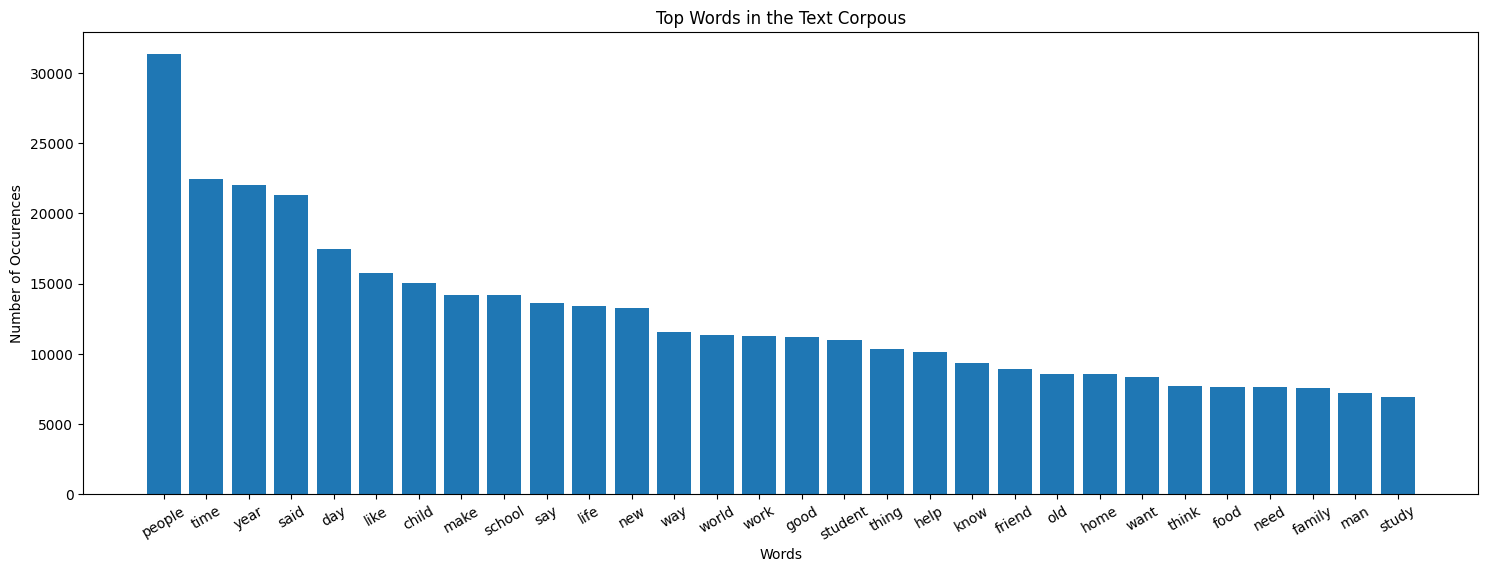

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")

top_n_words, word_counts = get_top_n_words(n_top_words=30, 
                                           count_vectorizer=cv,
                                           text_data=train_documents['clean_document'])

fig, ax = plt.subplots(figsize=(18,6))
ax.bar(range(1, len(top_n_words)+1), word_counts)
ax.set_xticks(range(1, len(top_n_words)+1))
ax.set_xticklabels(top_n_words, rotation=30)
ax.set_title("Top Words in the Text Corpous")
ax.set_xlabel("Words")
ax.set_ylabel("Number of Occurences")
plt.show();

### 4.2 Parts-of-Speech Tagging Analysis

In [25]:
from textblob import TextBlob

def stats_of_documents(data:pd.DataFrame):
    """
    Plots a BarPlot representing count of different Parts of Speech in the text corpus
    Params:
        data: pd.DataFrame, cleaned text dataframe
    """
    data = data['clean_document'].tolist()
    
    # PoS tagging
    tagged_documents = [TextBlob(data[i]).pos_tags for i in range(len(data))]
    tagged_documents_df = pd.DataFrame({'tags': tagged_documents})
    
    word_counts = []
    pos_counts = {}
    
    for tagged_text in tagged_documents_df['tags']:
        word_counts.append(len(tagged_text))
        
        for word, tag in tagged_text:
            if tag in pos_counts:
                pos_counts[tag] += 1
            else:
                pos_counts[tag] = 1
                
    print(f"Total number of words in the document: {np.sum(word_counts)}")
    print(f"Mean count of words per article in the document: {round(np.mean(word_counts))}")
    print(f"Minimum count of words of an article in the document: {np.min(word_counts)}")
    print(f"Maxmimum count of words of an article in the document: {np.max(word_counts)}")
    
    pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
    pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

    fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(range(len(pos_counts)), pos_sorted_counts)
    ax.set_xticks(range(len(pos_counts)))
    ax.set_xticklabels(pos_sorted_types, rotation=30)
    ax.set_title('Part-of-Speech Tagging for the Corpus of Articles')
    ax.set_xlabel('Type of Word')
    plt.show();

Total number of words in the document: 3704585
Mean count of words per article in the document: 147
Minimum count of words of an article in the document: 1
Maxmimum count of words of an article in the document: 634


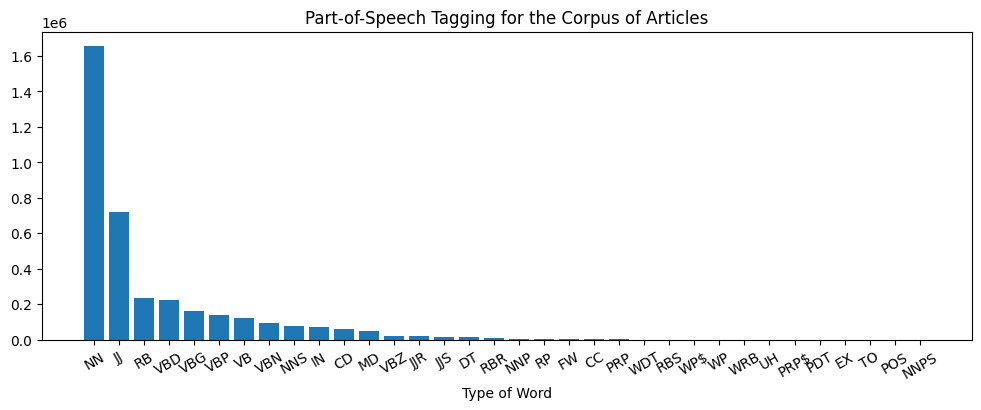

In [26]:
stats_of_documents(train_documents)

## 5. Topic Modelling: Latent Semantic Analysis(LSA)

LSA was unable to provide a greater degree of seperation as seen in t-SNE plot, almost all the documents belonged to a single topic, topic_0. LSA was unable to provide a greater degree of seperation as seen in t-SNE plot, almost all the documents belonged to a single topic, topic_0.

### 5.1 LSA

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fitting using TfIdf, 4000 features are taken as the threshold so words having sufficient count will only be taken.
# As our vocabulary is not diverse, most words are from noun and more or less they are talking about 
# people, children, school etc etc...

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=4000)

vect_text = vectorizer.fit_transform(train_documents['clean_document'])

In [28]:
from sklearn.decomposition import TruncatedSVD

# We will be going with the 10 topics as I tried with 15,20 topics but there was no improvement.
# n_iter is for 10 iterations with random_state as 42 to keep the results fixed

lsa_model = TruncatedSVD(n_components=10, algorithm='randomized',
                         n_iter=10, random_state=42)

lsa_top = lsa_model.fit_transform(vect_text)

In [29]:
lsa_model.get_params()

{'algorithm': 'randomized',
 'n_components': 10,
 'n_iter': 10,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0}

In [30]:
lsa_top.shape, vect_text.shape

((25139, 10), (25139, 4000))

In [31]:
# Let's see the weightage of each topic in the first document

print("Document 0 :")
for i, topic in enumerate(lsa_top[0]):
    print(i, "-->" ,topic)

Document 0 :
0 --> 0.184332149621413
1 --> -0.10041306072719978
2 --> 0.08315356414890313
3 --> -0.035955933474238845
4 --> 0.017866750202145055
5 --> -0.03561369780015151
6 --> 0.02234935203644984
7 --> -0.0204161080299732
8 --> -0.0834451439970469
9 --> -0.012983949858197823


In [32]:
def topics_document(model_output, n_topics , data):
    '''
    Returns a dataframe for each document having topic weightages
    and the dominant topic for each document.
    '''
    
    # column names
    topicnames = ["Topic_" + str(i) for i in range(n_topics)]
    
    # index names
    docnames = ["Doc_" + str(i) for i in range(len(data))]
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)
    
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    
    return df_document_topic

In [33]:
document_topic_lsa = topics_document(model_output=lsa_top, 
                                     n_topics=10, 
                                     data=train_documents)

document_topic_lsa

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,dominant_topic
Doc_0,0.18,-0.10,0.08,-0.04,0.02,-0.04,0.02,-0.02,-0.08,-0.01,0
Doc_1,0.13,-0.06,-0.03,-0.02,-0.00,-0.00,0.07,0.02,-0.08,-0.03,0
Doc_2,0.17,-0.03,-0.03,-0.02,0.02,-0.04,-0.01,-0.06,0.01,-0.01,0
Doc_3,0.10,-0.04,0.01,0.01,0.03,-0.00,-0.03,0.03,-0.02,-0.04,0
Doc_4,0.10,0.02,-0.07,-0.01,0.08,0.05,-0.02,-0.00,0.06,0.02,0
...,...,...,...,...,...,...,...,...,...,...,...
Doc_25134,0.12,-0.05,0.11,-0.02,0.04,-0.01,0.01,0.04,-0.03,0.03,0
Doc_25135,0.20,-0.07,-0.07,-0.11,-0.08,0.07,0.02,-0.20,-0.06,0.20,0
Doc_25136,0.23,0.12,0.02,-0.08,-0.04,-0.23,0.15,0.02,-0.08,-0.07,0
Doc_25137,0.21,-0.03,-0.03,0.02,0.04,-0.01,-0.06,0.02,0.00,-0.04,0


In [34]:
# In most of the documents topic_0 is dominant i.e most of the 
# documents is about topic_0
document_topic_lsa.dominant_topic.value_counts()

dominant_topic
0    21706
1      712
3      403
6      392
8      388
2      384
4      382
9      381
5      258
7      133
Name: count, dtype: int64

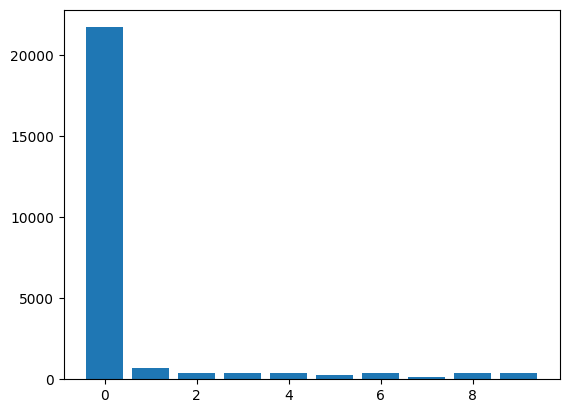

In [35]:
plt.bar(x = document_topic_lsa.dominant_topic.value_counts().index,
        height = document_topic_lsa.dominant_topic.value_counts().values);

* This plot is showing how the topics are not able to differentiate the words between them and the maximum documents almost more than 90% of the documents are assigned topic 0.

* Very few are documents are assigned other topics

In [36]:
vectorizer.get_feature_names_out()

array(['abandoned', 'ability', 'able', ..., 'zhang', 'zone', 'zoo'],
      dtype=object)

In [37]:
lsa_model.components_[0], lsa_model.components_[0].shape

(array([0.00227616, 0.02166587, 0.03353907, ..., 0.00774743, 0.00451889,
        0.00874563]),
 (4000,))

In [38]:
vectorizer.get_feature_names_out().shape, lsa_model.components_.shape

((4000,), (10, 4000))

* **Below we see what are the **top 10 words** for each documents, which gives us the idea what each topic is about.**


Here
```
Topic_0: 
people, school, child, said, time, year, student, day, like, life, 
```
In Topic_0, these are the most common words and 'people' has the most weightage in it.


So, based on the top_n words we can name a particular topic.

In [39]:
vocabulary = vectorizer.get_feature_names_out()

for i, component in enumerate(lsa_model.components_):
    vocab_comp = zip(vocabulary, component)
    
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    
    print("Topic_"+ str(i) + ": ")
    
    for t in sorted_words:
        print(t[0], end=", ")
        
    print("\n")

Topic_0: 
people, school, child, said, time, year, student, day, like, life, 

Topic_1: 
student, school, teacher, child, class, english, parent, education, college, language, 

Topic_2: 
mother, mr, father, man, boy, said, school, child, went, girl, 

Topic_3: 
child, parent, kid, family, life, feel, age, help, thing, make, 

Topic_4: 
english, language, book, word, friend, read, reading, people, learn, thing, 

Topic_5: 
child, chinese, china, english, book, language, city, year, world, country, 

Topic_6: 
food, english, eat, water, like, child, animal, chinese, school, language, 

Topic_7: 
english, language, woman, said, dog, food, chinese, study, man, animal, 

Topic_8: 
book, water, animal, dog, reading, read, plant, tree, story, scientist, 

Topic_9: 
car, english, child, language, mr, driver, road, bus, phone, driving, 



### 5.2.1 Visualizing topics with t-SNE

- [StatQuest: t-SNE, Clearly Explained](https://youtu.be/NEaUSP4YerM)
- [sklearn t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

* **t-Distributed Stochastic Neighbor Embedding (t-SNE)** is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

* The t-SNE algorithm reduces high-dimensional data into a lower-dimensional graph that retains a lot of the original information

- t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

    * KL is a statistical measure which is used to quantify how one distribution is different from another. Closer the value of **Kullback–Leibler(KL)** divergence to zero, the closeness of the corresponding words increases. In other words, the divergence value is less.

In [40]:
import numpy as np
from collections import Counter

# Define helper functions
def get_keys(topic_matrix):
    '''
    Returns an integer list of predicted topic categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


def get_mean_topic_vectors(keys, tSNE_vectors, n_topics):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(tSNE_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [41]:
colormap = np.array(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
                     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
                     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
                     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])

colormap = colormap[:10]

In [42]:
lsa_keys = get_keys(lsa_top)

lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [43]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, 
                      learning_rate=100, n_iter=2000, angle=0.75,
                      verbose=0, random_state=0)

tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_top)

In [46]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label


lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors, n_topics=10)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(10), 
              outer_width=700, outer_height=700)

plot.scatter(x = tsne_lsa_vectors[:,0], 
             y = tsne_lsa_vectors[:,1], 
             color = colormap[lsa_keys])

for t in range(10):
    label = Label(x = lsa_mean_topic_vectors[t][0], 
                  y = lsa_mean_topic_vectors[t][1], 
                  text_color = colormap[t])
    
    plot.add_layout(label)
    
show(plot)

* Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead the t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.

* In Almost all the documents, the dominant topic comes out to be topic_0 which is having the top 10 keywords as :
    ```
    Topic_0: 
    people, school, child, said, time, year, student, day, like, life, 
    ```
    
* **

### 5.2.2 Generating Word-Clouds

The more bigger the word is, the more frequency/weightage having for the word is and the smaller word gets, the lesser frequency/weightage for that word is

In [47]:
from wordcloud import WordCloud

# Generate a word cloud image for given topic

vocabulary = vectorizer.get_feature_names_out()

def draw_word_cloud(topic_index, model):
    imp_words_topic=""
    
    component = model.components_[topic_index]
    
    vocab_comp = zip(vocabulary, component)
    
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

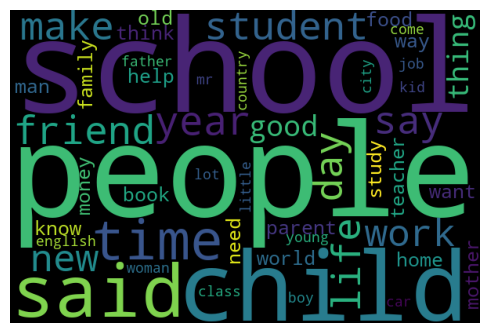

In [48]:
# Word Cloud for topic-0
draw_word_cloud(topic_index=0, model=lsa_model)

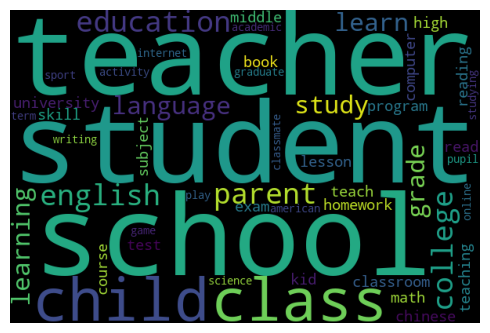

In [49]:
draw_word_cloud(1, lsa_model)

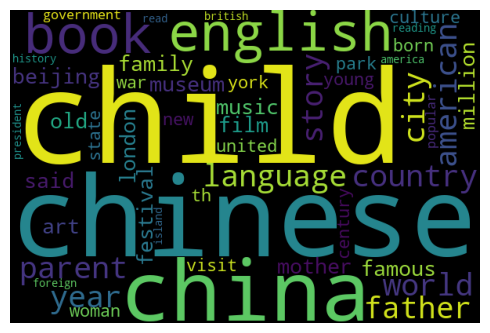

In [50]:
draw_word_cloud(5, lsa_model)

### 5.2.3 Predicting on test-documents

Total number of words in the document: 406228
Mean count of words per article in the document: 145
Minimum count of words of an article in the document: 8
Maxmimum count of words of an article in the document: 465


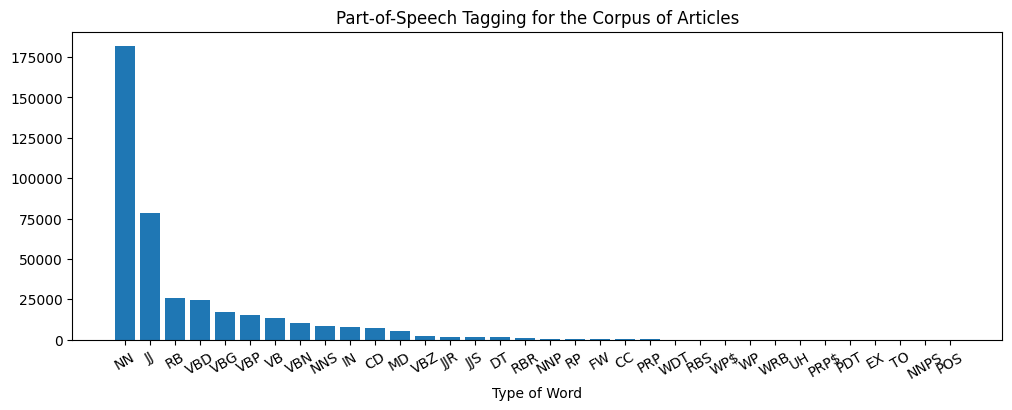

In [51]:
# Statistics for test-docs
stats_of_documents(test_documents)

In [52]:
vect_text_test = vectorizer.transform(test_documents['clean_document'])

lsa_top_test = lsa_model.transform(vect_text_test)

In [53]:
lsa_keys_test = get_keys(lsa_top_test)

lsa_categories_test, lsa_counts_test = keys_to_counts(lsa_keys_test)

lsa_categories_test, lsa_counts_test

([0, 1, 5, 8, 6, 3, 2, 9, 4, 7], [2376, 102, 33, 57, 54, 43, 45, 32, 40, 12])

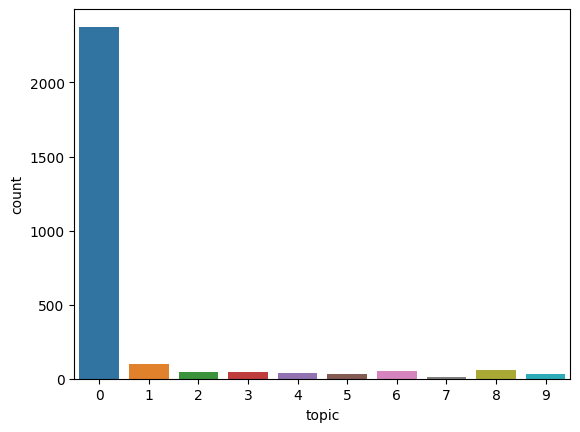

In [56]:
topics_df_test = pd.DataFrame({'topic' : lsa_categories_test, 'count' : lsa_counts_test})

sns.barplot(x=topics_df_test['topic'], y = topics_df_test['count'])

plt.show();

In [57]:
documet_topic_lsa_test = topics_document(model_output=lsa_top_test, 
                                         n_topics=10, 
                                         data=test_documents)
documet_topic_lsa_test

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,dominant_topic
Doc_0,0.14,-0.06,0.01,-0.01,0.02,0.00,0.01,-0.03,-0.05,-0.03,0
Doc_1,0.31,0.01,0.11,0.03,0.07,0.06,0.06,-0.11,0.27,-0.07,0
Doc_2,0.21,0.24,-0.09,-0.14,0.01,-0.04,-0.11,0.07,0.05,0.02,1
Doc_3,0.25,-0.05,0.03,0.05,0.13,-0.14,0.02,-0.03,-0.00,0.01,0
Doc_4,0.13,-0.04,-0.07,-0.04,-0.03,0.05,0.06,-0.07,-0.00,-0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
Doc_2789,0.14,-0.03,0.06,0.07,-0.00,-0.03,0.14,0.04,-0.08,-0.01,0
Doc_2790,0.14,-0.06,0.05,-0.01,0.06,-0.01,0.01,-0.04,-0.02,-0.04,0
Doc_2791,0.08,-0.02,-0.02,0.00,-0.02,0.08,0.01,-0.10,0.02,0.04,0
Doc_2792,0.11,-0.09,0.07,-0.03,0.01,0.00,-0.07,0.10,-0.02,-0.02,0


## 6. Topic Modelling: Latent Dirichlet Allocation(LDA)

Performed better than LSA

### 6.1 LDA - sklearn

- **Evaluation Metric:** [**Perplexity**](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

    - Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. **It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.**

    - Focussing on the log-likelihood part, *you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.*

    - **However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated.**

#### 6.1.1 LDA - Base Model

- **LDA is often works well with `CountVectorizer` rather than `Tfidf`**

- **You should use `CountVectorizer` when fitting LDA instead of `TfidfVectorizer` since LDA is based on term count and document count.** Fitting LDA with `TfidfVectorizer` will result in rare words being dis-proportionally sampled. As a result, they will have greater impact and influence on the final topic distribution. 

[**Source**](https://towardsdatascience.com/introduction-to-topic-modeling-using-scikit-learn-4c3f3290f5b9)

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

# Using count vectorizer to build the LDA model
vectorizer = CountVectorizer(analyzer="word",
                             min_df = 10, # Consider a word for the vocab. only if it occurs >= min_dif in whole corpus
                             stop_words="english",
                             lowercase=True)

vectorized_data = vectorizer.fit_transform(train_documents['clean_document'])

In [59]:
from sklearn.decomposition import LatentDirichletAllocation

# Build the model
lda_model = LatentDirichletAllocation(n_components=20, # Num of topics
                                      max_iter=10, # Max learning iterations
                                      learning_method="online",
                                      batch_size=128,
                                      evaluate_every=-1, # See doc, How often to evaluate perplexity
                                      random_state=42,
                                      n_jobs=-1)

lda_output = lda_model.fit_transform(vectorized_data)

print(lda_model) # attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=42)


* **Perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

* Focusing on the **log-likelihood** part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier

* A model with higher log-likelihood and lower perplexity $(= e^{-1.0 \times \text{log-likelihood per word}})$ is considered to be good.

In [60]:
# Log likelihood: Higher the better
print(f"Log Likelihood: {lda_model.score(vectorized_data)}")

# Perplexity: Lower the better
print(f"Perplexity: {lda_model.perplexity(vectorized_data)}")

Log Likelihood: -23719283.89460535
Perplexity: 2149.5522702477106


- On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

In [61]:
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


#### 6.1.2 Grid-Search

- The most important tuning parameter for LDA models is `n_components` (number of topics).

<!-- - In addition, I am going to search learning_decay (which controls the learning rate) as well. -->

- Besides these, other possible search params could be `learning_decay`, `learning_offset`(downweigh early iterations. Should be > 1), and `max_iter`. These could be worth experimenting if you have enough computing resources.


- `learning_decay` is in percentage, and states that what % of previous topic to be ignored to learn a new topic
    - It is a parameter that control learning rate in the online learning method. The value should be set between (0.5, 1.0] to guarantee asymptotic convergence.

In [62]:
%%time
# Grid Search

params = {'n_components': [10,15,20],
          'learning_decay': [.5, .7, .9]}

# Instantiate the model
lda = LatentDirichletAllocation(max_iter=5, 
                                learning_method="online", 
                                learning_offset=50., 
                                random_state=42)

lda_gs = GridSearchCV(estimator=lda, param_grid=params, n_jobs=-1)

lda_gs.fit(vectorized_data)

CPU times: total: 38.2 s
Wall time: 5min 12s


GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=42),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20]})

In [63]:
# Best Model
best_lda_model = lda_gs.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_gs.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_gs.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_data))


# Our model has improved comapared to previous one

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -4875472.497544647
Model Perplexity:  2106.5205094199514


#### 6.1.3 Analyzing the o/p of the best model

In [64]:
lda_output = best_lda_model.transform(vectorized_data)

In [65]:
document_topic_lda = topics_document(model_output=lda_output, n_topics=10, data=train_documents)
document_topic_lda

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,dominant_topic
Doc_0,0.00,0.25,0.00,0.11,0.00,0.00,0.04,0.00,0.00,0.59,9
Doc_1,0.04,0.04,0.01,0.38,0.04,0.00,0.00,0.12,0.09,0.28,3
Doc_2,0.17,0.10,0.00,0.16,0.07,0.24,0.01,0.00,0.00,0.24,5
Doc_3,0.00,0.00,0.00,0.00,0.40,0.21,0.29,0.09,0.00,0.00,4
Doc_4,0.00,0.27,0.00,0.01,0.00,0.50,0.00,0.22,0.00,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...
Doc_25134,0.00,0.18,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.66,9
Doc_25135,0.71,0.23,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0
Doc_25136,0.07,0.00,0.26,0.43,0.00,0.24,0.00,0.00,0.00,0.00,3
Doc_25137,0.00,0.01,0.01,0.17,0.00,0.35,0.04,0.13,0.00,0.27,5


In [66]:
document_topic_lda.dominant_topic.value_counts()

# As we can see as compared to lsa our dominant topics has been more diversified

dominant_topic
9    6117
5    5052
3    2876
4    2632
0    2021
1    2003
7    1566
8    1566
2     976
6     330
Name: count, dtype: int64

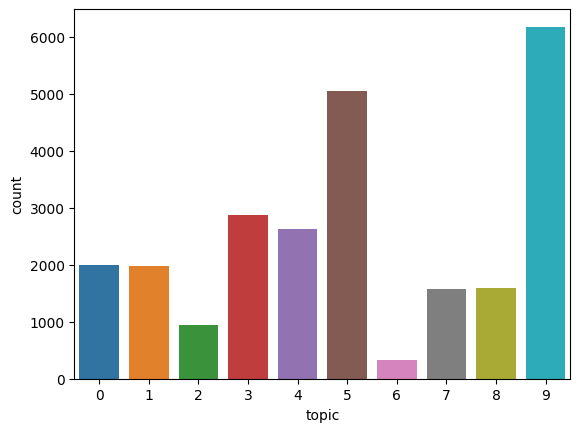

In [67]:
lda_keys = get_keys(lda_output)
# print(lda_keys[:10])

lda_categories, lda_counts = keys_to_counts(lda_keys)
# print(lda_categories, lda_counts)

topics_df_lda = pd.DataFrame({'topic' : lda_categories, 'count' : lda_counts})
sns.barplot(x=topics_df_lda['topic'], y = topics_df_lda['count'])
plt.show();

- Here documents are well distributed among diff. topics which was not the case in LSA

In [68]:
# Let's views top-n key words for each topic

def show_topic_keywords(vectorizer, model, top_n_words):
    """
    Gives top n key-words for each topic in the model
    
    :params:
        vectorizer: text-vectorizer
        model: lda model
        top_n_words: int,
    """
    keywords = np.array(vectorizer.get_feature_names_out()) # vocabulary of words built by the vectorizer
    
    topic_keywords = []
    
    for topic_weight in model.components_:
        top_keyword_locs = (-topic_weight).argsort()[:top_n_words]
        
        # -topic_weight, negative is applied so that we get index of words 
        # in desecending order of their prob. of occuranace in a topic
        
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

In [69]:
vectorizer.get_feature_names_out().shape, \
best_lda_model.components_.shape

((11514,), (10, 11514))

In [70]:
vocabulary_of_all_words = vectorizer.get_feature_names_out()

topic_0 = best_lda_model.components_[0]

best_lda_model.components_[0].shape

index_of_top15_most_relevent_words_in_topic0 = (-best_lda_model.components_[0]).argsort()[:15]

top15_keywords_in_topic0 = vocabulary_of_all_words.take(index_of_top15_most_relevent_words_in_topic0)

top15_keywords_in_topic0

array(['city', 'day', 'place', 'people', 'park', 'hotel', 'time', 'new',
       'visit', 'london', 'travel', 'year', 'trip', 'museum', 'world'],
      dtype=object)

In [71]:
topic_keywords = show_topic_keywords(vectorizer = vectorizer,
                                     model = best_lda_model,
                                     top_n_words=15)
# print(topic_keywords)

# topic-keyword dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)

topic_keywords_df.columns = ['Word '+ str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+ str(i) for i in range(topic_keywords_df.shape[0])]

topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,city,day,place,people,park,hotel,time,new,visit,london,travel,year,trip,museum,world
Topic 1,computer,phone,people,company,use,car,internet,money,online,new,buy,technology,time,make,store
Topic 2,child,parent,family,kid,year,mother,school,like,play,old,home,father,day,game,time
Topic 3,people,food,study,eat,body,say,researcher,health,time,sleep,brain,make,scientist,human,help
Topic 4,water,people,animal,year,tree,plant,air,earth,bird,world,space,sea,fish,make,scientist
Topic 5,student,school,people,time,make,life,teacher,work,good,english,help,thing,class,way,job
Topic 6,woman,music,men,black,white,song,girl,color,hair,wear,clothes,blue,elephant,like,look
Topic 7,book,story,world,read,people,year,word,movie,film,reading,life,famous,time,american,new
Topic 8,said,china,chinese,year,country,people,world,state,american,united,government,percent,team,beijing,million
Topic 9,said,day,man,time,mr,went,like,friend,know,asked,old,got,thing,came,little


#### 6.1.4 Visualizing LDA topics with t-SNE

In [72]:
from sklearn.manifold import TSNE

tsne_lda_model = TSNE(n_components=2, perplexity=50, 
                      learning_rate=100, n_iter=2000, angle=0.75,
                      verbose=0, random_state=0)

tsne_lda_vectors = tsne_lda_model.fit_transform(lda_output)

In [73]:
colormap = np.array(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
                     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
                     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
                     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])

colormap = colormap[:10]
colormap

array(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
       '#d62728', '#ff9896', '#9467bd', '#c5b0d5'], dtype='<U7')

In [75]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors, n_topics=10)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(10), 
              outer_width=700, outer_height=700)

plot.scatter(x = tsne_lda_vectors[:,0], 
             y = tsne_lda_vectors[:,1], 
             color = colormap[lda_keys])

for t in range(10):
    label = Label(x = lda_mean_topic_vectors[t][0], 
                  y = lda_mean_topic_vectors[t][1], 
                  text_color = colormap[t])
    
    plot.add_layout(label)
    
show(plot)

- **This is a much better result! LDA has had much more succcess than LSA in separating out the topic categories.**

#### 6.1.5 Visualizing using `pyLDAvis`

In [76]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { max-width:100% !important; }</style>"))
# display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
# display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
# display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

* **pyLDAvis** is a interactive LDA visualization python package. 

*  The area of circle represents the importance of each topic over the entire corpus, the distance between the center of circles indicate the similarity between topics.

* For each topic, the histogram on the right side listed the top 30 most relevant terms. 

In [77]:
import pyLDAvis
import pyLDAvis.lda_model # import pyLDAvis.sklearn -> this doesn't work

pyLDAvis.enable_notebook()

In [78]:
display_data = pyLDAvis.lda_model.prepare(best_lda_model, 
                                          vectorized_data,
                                          vectorizer)

In [79]:
pyLDAvis.display(display_data)  

##### [**Interpreting pyLDAvis plots**](https://towardsdatascience.com/latent-dirichlet-allocation-intuition-math-implementation-and-visualisation-63ccb616e094)

- Using pyLDAvis, the LDA data (which in our case, was 10-dimensional) has been decomposed via PCA (principal component analysis) to be only 2-dimensional. Thus it has been flattened for the purposes of visualisation. 

- We have ten circles and the center of each circle represents the position of our topic in the latent feature space; the distances between topics illustrates how (dis)similar the topics are and the area of the circles is proportional to how many documents feature each topic.

* **

* Each bubble represents a topic. 
    - The larger the bubble, the higher percentage of the number of articles in the corpus is about that topic.
    
* **
* Blue bars represent the overall frequency of each word in the corpus. 
    * If no topic is selected, the blue bars of the most frequently used words will be displayed.

* **

* Red bars give the estimated number of times a given term was generated by a given topic. 
    * As seen from the image above, there are about nearly 20000 of the word **people**, and this term is used about 5,000 times within topic2. <br></br>
    
* The word with the longest red bar is the word that is used the most by the articles belonging to that topic.

* **

* Now,looking at the right hand side of the plot there is a measure called 
    - **relevance**, which is similar to **exclusivity**: **it denotes the degree to which a term appears in a particular topic to the exclusion of others.**
    
    - Relevance is based on another metric, **lift**: **which is the ratio of a term’s probability within a topic to its margin probability across the corpus.** 
    
    
    * On one hand, it decreases the ranking of globally common terms, but on the other, it gives a high ranking to rare terms that occur in a single topic. 

    * Relevance is denoted by $\lambda$, the weight assigned to the probability of a term in a topic relative to its lift.
    
    * When $\lambda = 1$, the terms are ranked by their probabilities within the topic (the "regular" method) while when $\lambda = 0$, the terms are ranked only by their lift. 
    
    * The interface allows to adjust the value of $\lambda$ between 0 and 1.

    * An optimal value for $\lambda \text{ is in the range of [0.3, 0.6]}$ regarding the use of relevance to aid topic interpretation.

- **Relevance:**

    - This is an adjustable metric that balances a term’s frequency in a particular topic against the term’s frequency across the whole corpus of documents.

    - In other words, if we have a term that’s quite popular in a topic, relevance allows us to gauge how much of its popularity is due to it being very specific to that topic and how much of it is due to it just being a work that appears everywhere.
    
    
- **Adjusting $\lambda$ (lambda)**

    - If we set $\lambda$ equal to 1, then our relevance is given purely by the probability of the word to that topic. 
    
    - Setting $\lambda = 0$ will result in our relevance being dictated by specificity of that word to the topic — thus, highly frequent words will be downgraded heavily in relevance when we have a lower $\lambda$ value.

### 6.2 LDA - gensim

**Evaluation Metric:** [**Topic Coherence**](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

> ***Optimizing for perplexity may not yield human interpretable topics***

The limitations of perplexity measure served as a motivation for more work trying to model the human judgement, and thus Topic Coherence

1. **What is Topic Coherence?**

    - Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But $...$

2. **What is Coherence?**

    - A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

3. **Coherence Measures** : Let’s take quick look at different coherence measures, and how they are calculated:

    - `C_v` measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

    - `C_p` is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence

    - `C_uci` measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words

    - `C_umass` is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure

    - `C_npmi` is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)

    - `C_a` is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
    
    
- [Pointwise mutual information:](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

    - Pointwise Mutual Information(PMI), or point mutual information, **is a measure of association.** It compares the probability of two events occurring together to what this probability would be if the events were independent.

    - PMI has been described as "one of the most important concepts in NLP", where it "draws on the intuition that the best way to weigh the association between two words is to ask how much more the two words co-occur in [a corpus than we would have a priori expected them to appear by chance."
    
    
- PMI can be Normalized between [-1,+1] resulting in 
    - -1 for never occurring together, 
    - 0 for independence, and 
    - +1 for complete co-occurrence.

In [80]:
# gensim
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [81]:
# Simply converting cleaaaned text into list of words/tokens 

train_documents['clean_tokens'] = train_documents['clean_document'].progress_apply(lambda x: x.split())

Progress Bar: 100%|██████████| 25139/25139 [00:00<00:00, 90096.15it/s]


In [82]:
# train_documents['clean_tokens'][0]

In [83]:
# tokenized form of cleaned documents
docs = train_documents['clean_tokens']

# Create a dictionary representation of the documents.
# In gensim a dictionary is a mapping between words and their integer_id.
dictionary = Dictionary(docs)

# Filter out words that occur less than 3 documents, or more than 85% of the documents.
# keep_n : Keep only the first 4000 most frequent tokens.
dictionary.filter_extremes(no_below=20, no_above=0.85, keep_n=4000)

In [84]:
len(dictionary.keys())

4000

In [85]:
# Bag-of-words representation of the documents. (list of (token_id, token_count))
corpus = [dictionary.doc2bow(doc) for doc in docs]

# corpus[0]

- `chunksize` controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

- `passes` controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. 

- `iterations` is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of `passes` and `iterations` high enough.

In [86]:
# Building LDA Model
lda_model_gensim = gensim.models.LdaMulticore(corpus=corpus,
                                              num_topics=10, 
                                              id2word=dictionary,
                                              chunksize=1000,
                                              passes=10,
                                              iterations=100,
                                              per_word_topics=True,
                                              random_state=42,
                                              workers=None)

In [87]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherennce score
coherence_model_lda = CoherenceModel(model=lda_model_gensim, 
                                     texts=docs,
                                     dictionary=dictionary,
                                     coherence="c_v")

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: %.4f' % coherence_lda)

Coherence Score: 0.3544


In [88]:
lda_model_gensim.print_topic(topicno=0, topn=15)

'0.021*"people" + 0.009*"make" + 0.008*"like" + 0.008*"time" + 0.008*"one" + 0.007*"use" + 0.007*"many" + 0.006*"thing" + 0.006*"say" + 0.006*"way" + 0.006*"may" + 0.006*"phone" + 0.006*"computer" + 0.006*"also" + 0.005*"get"'

In [89]:
import re

print(re.findall(r'"([^"]+)"',lda_model_gensim.print_topic(topicno=0, topn=15)))

['people', 'make', 'like', 'time', 'one', 'use', 'many', 'thing', 'say', 'way', 'may', 'phone', 'computer', 'also', 'get']


In [90]:
# Top-15 words in each topic

import re

topic_keywords_gensim = []

for i in range(10):
    topic_i = lda_model_gensim.print_topic(topicno=i, topn=15)
    topic_i = re.findall(r'"([^"]+)"', topic_i)
    topic_keywords_gensim.append(topic_i)

# topic-keyword dataframe
topic_keywords_gensim_df = pd.DataFrame(topic_keywords_gensim)

topic_keywords_gensim_df.columns = ['Word '+ str(i) for i in range(topic_keywords_gensim_df.shape[1])]
topic_keywords_gensim_df.index = ['Topic '+ str(i) for i in range(topic_keywords_gensim_df.shape[0])]

topic_keywords_gensim_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,people,make,like,time,one,use,many,thing,say,way,may,phone,computer,also,get
Topic 1,people,book,music,one,year,life,many,story,world,like,time,first,new,film,chinese
Topic 2,year,one,said,time,first,game,work,world,day,school,job,people,team,would,new
Topic 3,people,water,year,many,one,city,world,animal,plant,tree,earth,also,like,place,make
Topic 4,people,english,study,time,language,sleep,day,food,one,may,also,word,brain,help,make
Topic 5,school,student,child,time,teacher,life,parent,people,one,make,friend,class,good,get,say
Topic 6,child,year,people,would,family,one,parent,life,day,time,help,mother,friend,like,make
Topic 7,said,people,year,human,scientist,one,could,animal,dog,say,also,new,researcher,would,study
Topic 8,said,one,day,man,would,could,time,old,go,mr,like,went,asked,back,mother
Topic 9,china,year,chinese,people,time,day,said,city,one,country,new,also,student,many,world


In [91]:
# num_topics = 10
# top_topics = lda_model_gensim.top_topics(corpus=corpus, 
#                                          texts=docs, 
#                                          dictionary=dictionary,
#                                          coherence='c_v')

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# # from pprint import pprint
# # pprint(top_topics)

In [92]:
# Keywords for topic_0
# top_topics[0][0]

## 7. Topic Modeling: Non-Negative Matrix Factorization (NMF)

Performed well!

- [Gensim - Nmf - Docs](https://radimrehurek.com/gensim/models/nmf.html)
- [Sklearn - NMF - Docs](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

### 7.1 NMF

In [93]:
# gensim
import gensim
from gensim import models
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from sklearn.feature_extraction.text import TfidfVectorizer

from operator import itemgetter

In [94]:
train_documents['clean_tokens'] = train_documents['clean_document'].progress_apply(lambda x: x.split())

docs = train_documents['clean_tokens']

Progress Bar: 100%|██████████| 25139/25139 [00:00<00:00, 90302.64it/s]


In [95]:
# NMF is used with Tfidf for optimal results
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.85,
                                   max_features=4000, 
                                   ngram_range=(1, 2), # bi-gram also
                                   preprocessor=" ".join)

vectorized_text = tfidf_vectorizer.fit_transform(docs)

In [96]:
vectorized_text.shape

(25139, 4000)

In [97]:
dictionary = Dictionary(docs)

# Filter out words that occur less than 3 documents, or more than 85% of the documents.
# keep_n : Keep only the first 4000 most frequent tokens.
dictionary.filter_extremes(no_below=20, no_above=0.85, keep_n=4000)

# Bag-of-words representation of the documents. (list of (token_id, token_count))
corpus = [dictionary.doc2bow(doc) for doc in docs]

### 7.2 Getting Optimal No. of Topics

In [98]:
# Create a list of topic-numbers that we want to try
topic_nums = list(np.arange(5,25,))

In [99]:
%%time

# Create NMF models for each topic_nums and store their coherence score
coherence_scores = []

for num in topic_nums:
    # NMF model
    # See gensim doc to understand the meaning of these params: https://radimrehurek.com/gensim/models/nmf.html
    nmf = gensim.models.nmf.Nmf(corpus=corpus, num_topics=num,
                                id2word=dictionary, chunksize=2000,
                                passes=5, kappa=0.1, minimum_probability=0.01,
                                w_max_iter=300, w_stop_condition=0.0001,
                                h_max_iter=100, h_stop_condition=0.001,
                                eval_every=10, normalize=True,
                                random_state=42)
    
    # Coherence Model
    cm = CoherenceModel(model=nmf, texts=docs,
                        dictionary=dictionary, coherence="c_v")
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
    
# Get the topic number with highest coherence score
scores = list(zip(topic_nums, coherence_scores))

best_topic_number = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

CPU times: total: 2min 6s
Wall time: 8min 36s


In [100]:
print("# Topics with best coherence score: %s" %best_topic_number)

# Topics with best coherence score: 22


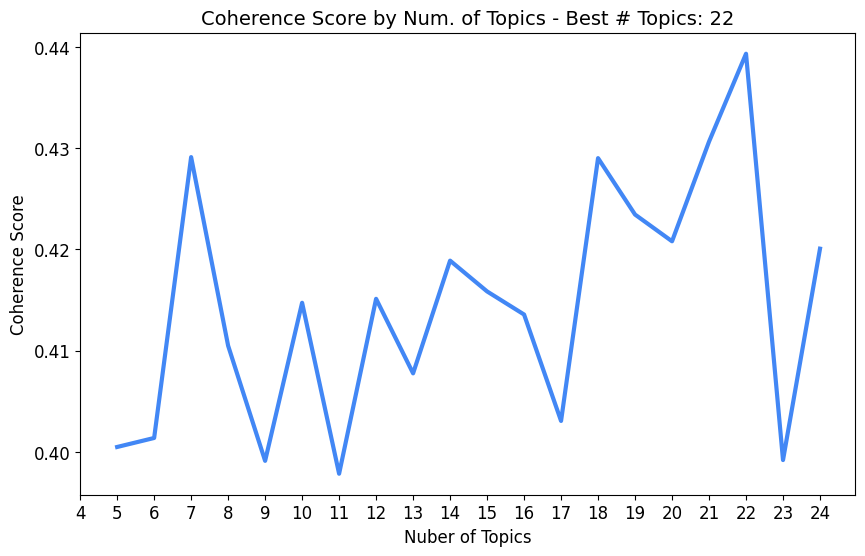

In [101]:
# Plot the results
fig = plt.figure(figsize=(10,6))

plt.plot(topic_nums, coherence_scores,
         linewidth=3, color='#4287f5')

plt.xlabel("Nuber of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.title('Coherence Score by Num. of Topics - Best # Topics: {}'.format(best_topic_number), fontsize=14)

plt.xticks(np.arange(4, max(topic_nums) + 1), fontsize=12)
plt.yticks(fontsize=12)

plt.show();

### 7.3 Proceding with 22 topics in NMF

In [102]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=22, init="nndsvd", random_state=42)

nmf_output = nmf.fit_transform(vectorized_text)

In [103]:
nmf_feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_weights = nmf.components_

In [104]:
nmf_weights.shape, nmf_feature_names.shape

((22, 4000), (4000,))

### 7.4 Visualizing top-15 terms of first two topics 

In [105]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    """
    Returns the learned weights along with their respective terms in descending order
    """
    # get all the words in the vocabulary
    feature_names = np.array(feature_names)
    
    # get the indices of the weights sorted in descending order
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    # get the sorted weights in descending order
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    
    # get the respetive words of the sorted weights
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    # storing the words and their learned weights together, arranged in ascending order of weights 
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics obtained from topic modeling
def print_topics_udf(topics, total_topics=1, weight_threshold=0.0001,
                     display_weights=False, num_terms=10):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+ str(index+1) + ' with weights')
            print(topic[:num_terms], "\n")
        else:
            print('Topic #' + str(index+1) + ' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms], "\n") 

# prints components of all the topics obtained from topic modeling
def get_topics_udf(topics, total_topics=1, weight_threshold=0.0001, num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def getTermsAndSizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

In [106]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
topics[0]

array([['friend', '1.7433276859639886'],
       ['people', '1.7230432335067039'],
       ['make', '1.2119761233046886'],
       ...,
       ['mar', '0.0'],
       ['many student', '0.0'],
       ['zoo', '0.0']], dtype='<U32')

In [107]:
print_topics_udf(topics=topics, total_topics=2, num_terms=15)

Topic #1 without weights
['friend', 'people', 'make', 'thing', 'life', 'feel', 'good', 'time', 'want', 'think', 'know', 'like', 'person', 'get', 'way'] 

Topic #2 without weights
['student', 'school', 'teacher', 'class', 'high school', 'college', 'education', 'high', 'grade', 'university', 'classroom', 'school student', 'test', 'middle school', 'study'] 



In [108]:
print_topics_udf(topics=topics, total_topics=2, num_terms=10, display_weights=True)

Topic #1 with weights
[('friend', 1.74), ('people', 1.72), ('make', 1.21), ('thing', 1.21), ('life', 1.14), ('feel', 0.93), ('good', 0.93), ('time', 0.87), ('want', 0.87), ('think', 0.86)] 

Topic #2 with weights
[('student', 2.44), ('school', 2.23), ('teacher', 0.98), ('class', 0.79), ('high school', 0.56), ('college', 0.53), ('education', 0.47), ('high', 0.46), ('grade', 0.34), ('university', 0.33)] 



In [109]:
topics_display_list = get_topics_udf(topics, total_topics=2, num_terms=15)
topics_display_list[1]

[('student', 2.44),
 ('school', 2.23),
 ('teacher', 0.98),
 ('class', 0.79),
 ('high school', 0.56),
 ('college', 0.53),
 ('education', 0.47),
 ('high', 0.46),
 ('grade', 0.34),
 ('university', 0.33),
 ('classroom', 0.29),
 ('school student', 0.26),
 ('test', 0.25),
 ('middle school', 0.24),
 ('study', 0.24)]

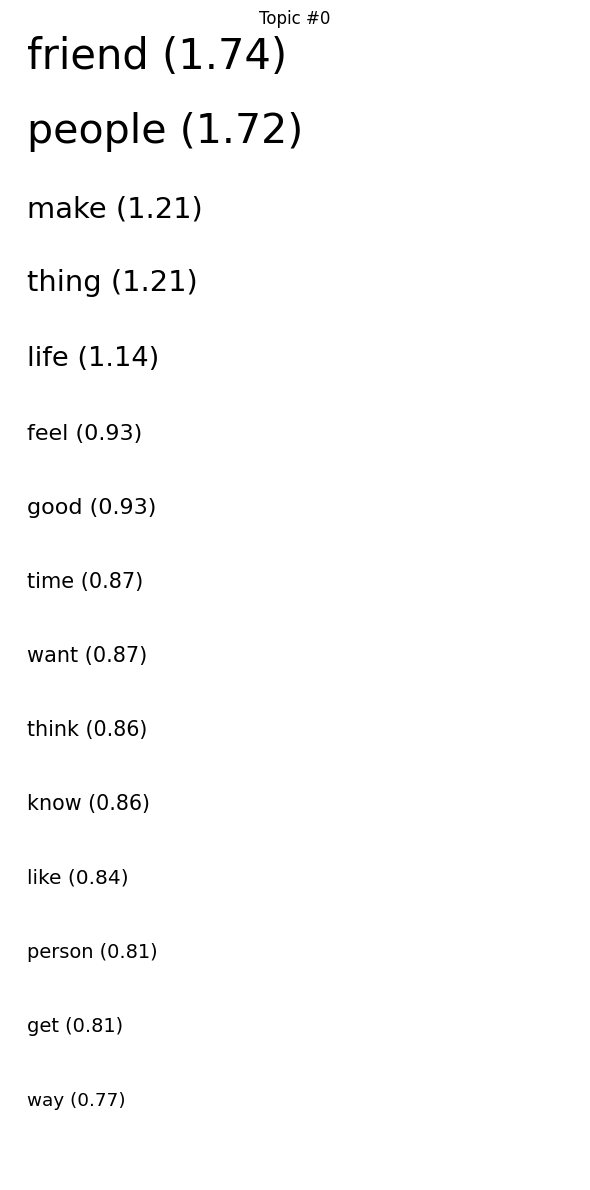

In [110]:
terms, sizes = getTermsAndSizes(topics_display_list[0])

num_top_words = 15
fontsize_base = 30 / np.max(sizes) # font size for word with largest share in corpus

num_topics = 1

for t in range(num_topics):
    fig, ax = plt.subplots(1, num_topics, figsize=(6, 12))
    plt.ylim(0, num_top_words+0.5)
    plt.axis("off")
    plt.title('Topic #{}'.format(t))

    for i, (word, share) in enumerate(zip(terms, sizes)):
        word = word + " (" + str(share) + ")"
        plt.text(0.03, num_top_words-i, word, fontsize=fontsize_base*share)

plt.tight_layout();

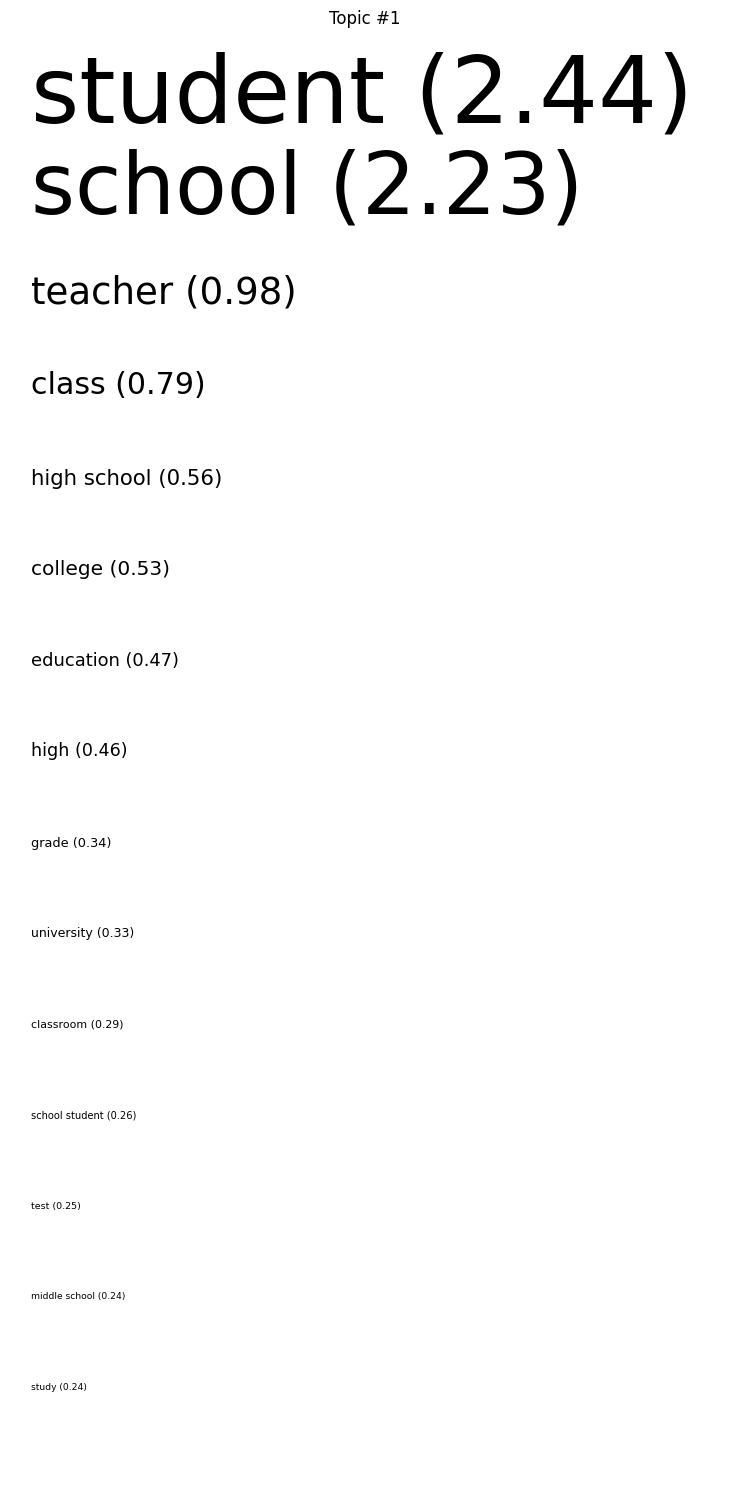

In [111]:
terms, sizes = getTermsAndSizes(topics_display_list[1])

num_top_words = 15
fontsize_base = 50/(np.max(sizes)*0.75) # font size for word with largest share in corpus

num_topics = 1

for t in range(num_topics):
    fig, ax = plt.subplots(1, num_topics, figsize=(8, 15))
    plt.ylim(0, num_top_words+1)
    plt.axis("off")
    plt.title('Topic #{}'.format(t+1))

    for i, (word, share) in enumerate(zip(terms, sizes)):
        word = word + " (" + str(share) + ")"
        plt.text(0.03, num_top_words-i, word, fontsize=fontsize_base*share)

plt.tight_layout();

### 7.5 Distribution of topics among diff. documents

In [112]:
documet_topic_nmf = topics_document(nmf_output, n_topics=22, data=train_documents)
documet_topic_nmf

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,dominant_topic
Doc_0,0.01,0.00,0.04,0.00,0.00,0.00,0.02,0.00,0.00,0.00,...,0.02,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,2
Doc_1,0.01,0.00,0.02,0.00,0.00,0.01,0.02,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,2
Doc_2,0.02,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.03,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,8
Doc_3,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,...,0.00,0.04,0.00,0.01,0.00,0.00,0.01,0.00,0.00,14
Doc_4,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,...,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc_25134,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.08,0.00,0.03,0.00,0.00,0.00,16
Doc_25135,0.01,0.01,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
Doc_25136,0.01,0.05,0.01,0.00,0.00,0.00,0.05,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.00,0.00,0.05,0.00,0.00,1
Doc_25137,0.02,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,...,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0


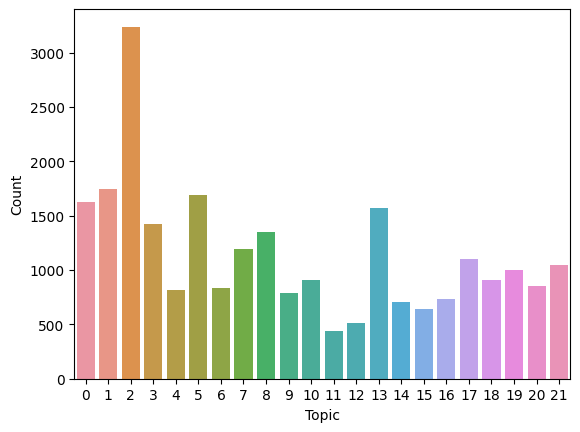

In [113]:
nmf_keys = get_keys(nmf_output)
nmf_categories, nmf_counts = keys_to_counts(nmf_keys)

topics_df_nmf = pd.DataFrame({'Topic' : nmf_categories, 'Count' : nmf_counts})
sns.barplot(x=topics_df_nmf['Topic'], y = topics_df_nmf['Count'])
plt.show();

### 7.6 Top-10 terms in each topic

In [114]:
vocab = tfidf_vectorizer.get_feature_names_out()

for i, comp in enumerate(nmf.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+ str(i)+ ": ")
    for t in sorted_words:
        print(t[0], end=", ")
    print("\n")

Topic 0: 
friend, people, make, thing, life, feel, good, time, want, think, 

Topic 1: 
student, school, teacher, class, high school, college, education, high, grade, university, 

Topic 2: 
mother, said, would, father, day, could, boy, went, asked, dad, 

Topic 3: 
child, parent, kid, family, school, adult, age, young, mother, home, 

Topic 4: 
english, language, word, speak, learn, learning, speaking, english language, foreign, speaker, 

Topic 5: 
city, world, museum, year, people, london, new, place, park, country, 

Topic 6: 
food, eat, eating, meal, vegetable, healthy, meat, fruit, restaurant, fat, 

Topic 7: 
study, researcher, brain, health, people, said, university, research, percent, disease, 

Topic 8: 
earth, plant, space, tree, planet, air, scientist, moon, sun, light, 

Topic 9: 
car, driver, road, driving, traffic, bus, drive, accident, vehicle, bike, 

Topic 10: 
book, reading, read, story, library, reader, writer, writing, novel, write, 

Topic 11: 
dog, pet, cat, owne

### 7.7 Visualizing topics using pyLDAvis

In [115]:
panel = pyLDAvis.lda_model.prepare(nmf, vectorized_text, tfidf_vectorizer, mds='tsne')

pyLDAvis.display(panel)

### 7.8 Prediction of test documents

In [116]:
test_documents['clean_tokens'] = test_documents['clean_document'].progress_apply(lambda x: x.split())

Progress Bar: 100%|██████████| 2794/2794 [00:00<00:00, 121238.21it/s]


In [117]:
vectorized_test_text = tfidf_vectorizer.transform(test_documents['clean_tokens'])

nmf_top_test = nmf.transform(vectorized_test_text)

In [118]:
documet_topic_nmf_test = topics_document(nmf_top_test, n_topics=22, data=test_documents)
documet_topic_nmf_test

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,dominant_topic
Doc_0,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.01,...,0.00,0.01,0.03,0.00,0.00,0.02,0.00,0.00,0.00,15
Doc_1,0.00,0.02,0.05,0.02,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.05,10
Doc_2,0.00,0.07,0.00,0.00,0.03,0.01,0.00,0.02,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
Doc_3,0.04,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0
Doc_4,0.01,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.0,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.02,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc_2789,0.00,0.00,0.02,0.03,0.00,0.00,0.04,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,6
Doc_2790,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.00,0.00,18
Doc_2791,0.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.0,0.00,...,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13
Doc_2792,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.0,0.00,...,0.00,0.06,0.00,0.00,0.00,0.08,0.00,0.00,0.00,18


In [119]:
panel = pyLDAvis.lda_model.prepare(nmf, vectorized_test_text, tfidf_vectorizer, mds='tsne')

pyLDAvis.display(panel)

## Conclusion

* We wil be proceeding with **NMF** though Coherence of LDA is a bit more but using pyLDAvis plot and topic distirbution for the words, the topics are much distributed clearly giving significant differences in the top words

* Though it is proven that LDA is quite stable and is the state of the art model.

* Hence, we will be going final with the LDA as well as NMF

## Generate requirements.txt

- References:

    - [Reference-1](https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52)
    - [Reference-2](https://stackoverflow.com/questions/51503913/pipreqs-unicodedecodeerror-charmap-codec-cant-decode-byte-0x98-in-position)

- Install

    - `pip install pipreqs`
    - `pip install nbconvert`
    
- Convert your jupyter notebook to .py file

    - `jupyter nbconvert --output-dir="./reqs" --to script "notebook_name.ipynb"`
    - `cd reqs (Navigate to the .py file directory)`

- Run the following command in .py file folder

    - `pipreqs "file_path"`
    - `pipreqs --encoding=utf8 "file_path"` (if above does not works)